# Exploratory Data Analysis (EDA) for Phishing Email

In [1]:
#!pip install langdetect
#!pip install wordcloud
#!pip install nltk

In [2]:
import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm
import prepare # adopted from: https://github.com/m3redithw/data-science-visualizations/blob/main/WordClouds/prepare.py
plt.rcParams["figure.figsize"] = (10,5)

## Reading the dataset

In [4]:
df = pd.read_csv(r"phishing_email.csv")
USE_CACHE = True

## check for missing data
In this section, we will evaluate the presence of missing data or rows which contain only white spaces.

In [5]:
text_column = "text_combined"
target_column = "label"

num_missing_texts = df.isnull()[text_column].sum()
if num_missing_texts > 0:
    print("There are %s missing rows"%(num_missing_texts))
else:
    print("There are no missing rows")

There are no missing rows


In [38]:
num_missing_texts = df[text_column].apply(lambda x: x.isspace()).sum()
if num_missing_texts > 0:
    print("There are %s rows contains only spaces"%(num_missing_texts))
else:
    print("rows contains only spaces")

There are 1 rows contains only spaces


## check class balance

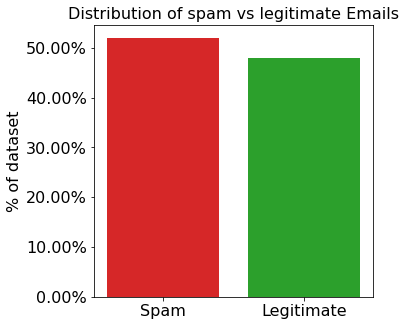

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

labels = ["Spam", "Legitimate"]
counts = df[target_column].value_counts(normalize=True).values *100
bar_labels = ['red', 'green']
bar_colors = ['tab:red', 'tab:green']

ax.bar(labels, counts, color=bar_colors)

ax.set_ylabel('% of dataset', fontsize=16)
ax.yaxis.set_major_formatter('{x:1.2f}%')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Distribution of spam vs legitimate Emails", fontsize=16)

plt.show()

**Insight:** With 52% of the dataset containing spam and 48% containing legitimate emails, we can consider the dataset to be fairly balanced.

## Distribution of languages in the data set

In [7]:
if not USE_CACHE:
    langs = []
    for i in tqdm(list(df[text_column])):
        try:
            langs.append(detect(i))
        except:
            langs.append("?")
    df.to_csv("with_lang.csv")
    df["lang"] = langs
else:
    df = pd.read_csv(r"with_lang.csv")

In [8]:
df_not_en  = df.loc[df["lang"] != "en"]
print("there are %s emails not in English (%.2f of the dataset)"%(len(df_not_en), 1-(len(df)-len(df_not_en))/len(df)))

there are 1725 emails not in English (0.02 of the dataset)


Text(0.5, 1.0, 'Distribution of spam vs legitimate Emails')

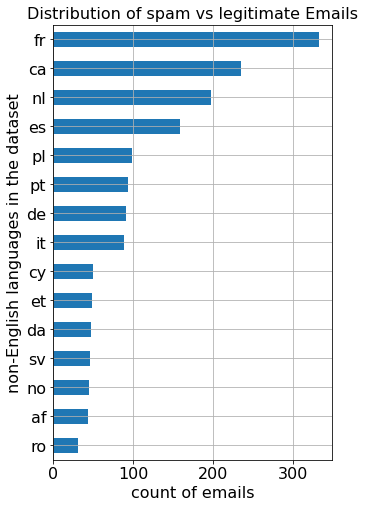

In [9]:
fig, ax = plt.subplots(figsize=(5, 8))
(df_not_en.groupby("lang").count()["text_combined"]).sort_values(ascending=True).tail(15).plot.barh(ax=ax)
plt.grid()

ax.set_ylabel('non-English languages in the dataset', fontsize=16)
ax.set_xlabel('count of emails', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Distribution of spam vs legitimate Emails", fontsize=16)

**Insight:** The majority (98%) of the dataset is in English. Given that the second most common language in the dataset is French, with approximately 300 emails, it appears impractical to train a French email classifier. Therefore, to avoid introducing potential confusion to the model, we will exclude non-English emails from the dataset.

## text statisitics

In this context, we have incorporated several features from the field of "Author Profiling" to distinguish between the statistical characteristics of legitimate emails and spam. Prominent patterns identified may be utilized as features for the model. The extracted features include:

**num_chars** - The number of characters in the mail.

**num_tokens** - The number of tokens in the email, here defined simply by counting spaces rather than using a tokenizer.

**non_alpha_numeric_ratio** - The ratio of non-alphanumeric characters to the total number of characters in the email.

**numeric_ratio** - The ratio of numeric characters to the total number of characters in the email.

In [10]:
df["num_chars"] = df[text_column].apply(len)
df["num_tokens"] = df[text_column].apply(lambda x: len(x.split(" ")))
df["non_alpha_numeric_ratio"] = df[text_column].apply(lambda x: 1- (sum(1 for c in x if c.isalnum())/len(x)))
df["numeric_ratio"] = df[text_column].apply(lambda x: sum(1 for c in x if c.isnumeric())/len(x))

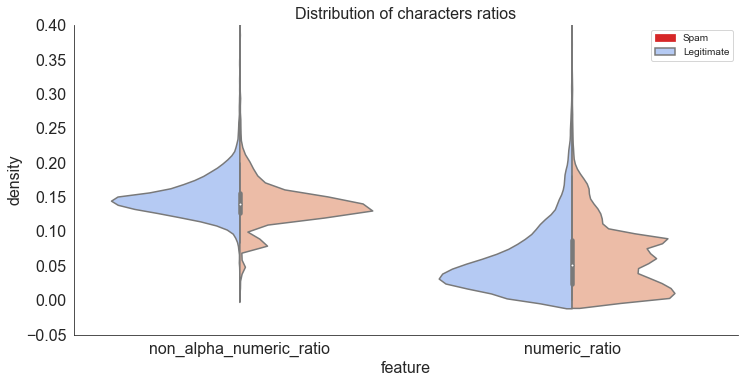

In [11]:
df_long = df.melt(id_vars=['Unnamed: 0', 'label'], value_vars=['non_alpha_numeric_ratio', 'numeric_ratio'])
sns.set_style('white')
ax = sns.violinplot(data=df_long , x='variable', y='value', hue='label', split=True, palette="coolwarm")
sns.despine()
plt.tight_layout()
plt.ylim([-0.05,0.4])
ax.set_ylabel('density', fontsize=16)
ax.set_xlabel('feature', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Distribution of characters ratios", fontsize=16)
ax.legend(labels=['Spam','Legitimate',])
leg = ax.get_legend()
leg.legendHandles[0].set_color('tab:red')
plt.show()

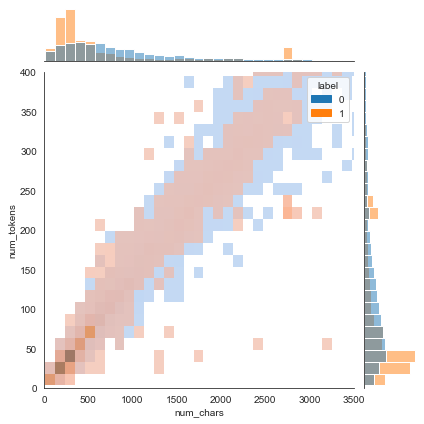

In [14]:
sns.jointplot(x="num_chars", y="num_tokens", hue="label",data=df.sample(frac=0.09),xlim=(0, 3500), ylim=(0, 400), kind="hist",alpha=0.7)

**Insights:**
 - The violin plots reveal that most spam emails have a distribution similar to that of legitimate emails. However, spam emails exhibit a bimodal distribution, with some emails containing fewer non-alphanumeric characters than expected and others containing more numeric characters than expected. For these emails, the aforementioned features may be useful in classifying them as spam.
 - The joint distribution plot suggests that many spam emails tend to be shorter than legitimate ones. However, overall, the joint distributions of spam and legitimate emails are quite similar.

## word clouds

A visualization technique that shows the frequency of words in a given body of text by adjusting the size of each word in proportion to its frequency is called a word cloud. Generating word clouds for spam and legitimate emails could provide insights into how the vocabulary differs between the two categories.

To generate the word cloud, a script was used to clean the data. This script normalizes the strings, lemmatizes the words, and removes stopwords.

In [24]:
USE_CACHE=True
if not USE_CACHE:
    preproc_df = df.copy()
    preproc_df["cleaned"] = df[text_column].apply(lambda x: str(prepare.clean(x))) # use script to clean the text
    preproc_df.to_csv("preproc_df.csv", index=False)
else:
    preproc_df = pd.read_csv(r"preproc_df.csv")

In [45]:
preproc_df = preproc_df.loc[preproc_df[text_column] != ' '] # ignore the row which contain only spaces

# chain the cleaned data to long string of spam/legitimate tokens
spam_words = ' '.join(preproc_df.loc[df[target_column] == 1]["cleaned"])
legit_words = ' '.join(preproc_df.loc[df[target_column] == 0]["cleaned"])
stopwords = set(STOPWORDS) # convert built-in stopwords to set

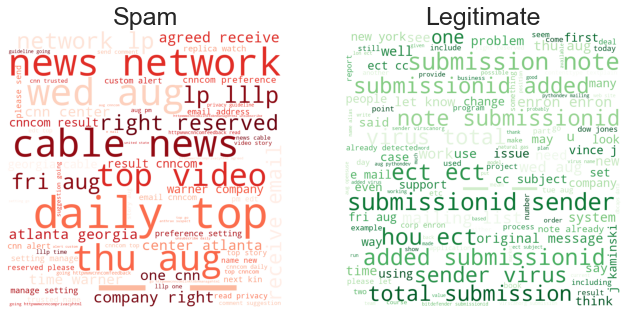

In [46]:
# generate word clouds
wordcloud_spam = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap ='Reds',
                min_font_size = 10).generate(spam_words)

wordcloud_legit = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap ='Greens',
                min_font_size = 10).generate(legit_words)
                      
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam)
plt.xlabel("Spam")
plt.axis("off")
plt.tight_layout(pad = 3)
plt.title("Spam", fontsize=25)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_legit)
plt.xlabel("Legitimate")
plt.axis("off")
plt.tight_layout(pad = 3)
plt.title("Legitimate", fontsize=25)
plt.show()

**Insights:**
- The term "submission," which appears frequently in the legitimate word cloud, suggests that the dataset contains a significant number of automated emails, likely related to the submission of forms or similar actions.
- The high frequency of the term "Enron" in the legitimate word cloud can be attributed to the fact that the dataset includes the "Enron Corpus," a well-known email dataset.
- The terms "daily" and "news," which frequently appear in the spam word cloud, may be related to newsletters that recipients have subscribed to but now consider as spam.

## word frequencies

In [50]:
# count token occurrences
spam_df = Counter(spam_words.split(" "))
spam_df = pd.DataFrame({'word':spam_df.keys(), 'count':spam_df.values()})
spam_df.sort_values(by="count", inplace = True, ascending = False)
spam_df.reset_index(drop=True, inplace = True)

In [51]:
legit_df = Counter(legit_words.split(" "))
legit_df = pd.DataFrame({'word':legit_df.keys(), 'count':legit_df.values()})
legit_df.sort_values(by="count", inplace = True, ascending = False)
legit_df.reset_index(drop=True, inplace = True)

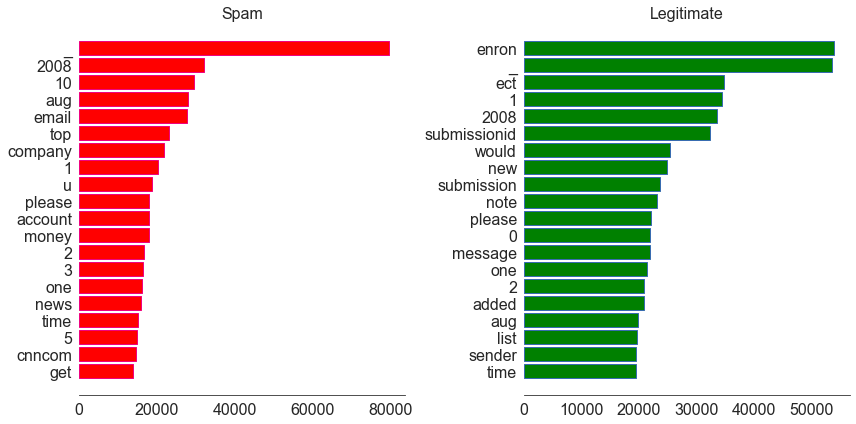

In [52]:
# pick top tokens
spam_10 =spam_df.iloc[:20]
legit_10 = legit_df.iloc[:20]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

# horizontal barplot:

ax1.barh(spam_10["word"], spam_10["count"], 
        color = "red", 
        edgecolor = "#f0027f")

ax2.barh(legit_10["word"], legit_10["count"], 
        color = "green", 
        edgecolor = "#386cb0")


# title:
ax1.set_title("Spam", fontsize=16)
ax2.set_title("Legitimate", fontsize=16)


for ax in fig.axes:                             
    ax.invert_yaxis()                           
    ax.grid(False)                              
                     
    ax.tick_params(axis='x', labelsize=16)    
    ax.tick_params(axis='y', labelsize=16)    
               
    ax.spines["top"].set_visible(False)         
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)


# layout:
fig.tight_layout()

plt.show()

**Insight:** This representation offers an alternative view of the word clouds previously presented. It is evident that several words frequently occur in both the legitimate and spam barcharts.

In [53]:
# In order to filter out the words which are common on both classes we are calculating the proportions
spam_df["proportion"] = spam_df["count"]/sum(spam_df["count"])
legit_df["proportion"] = legit_df["count"]/sum(legit_df["count"])

spam_legit = spam_df[["word", "proportion"]].merge(
    legit_df[["word", "proportion"]], 
    on = "word", 
    how = "outer", 
    suffixes = ("_spam", "_legit")).fillna(0)

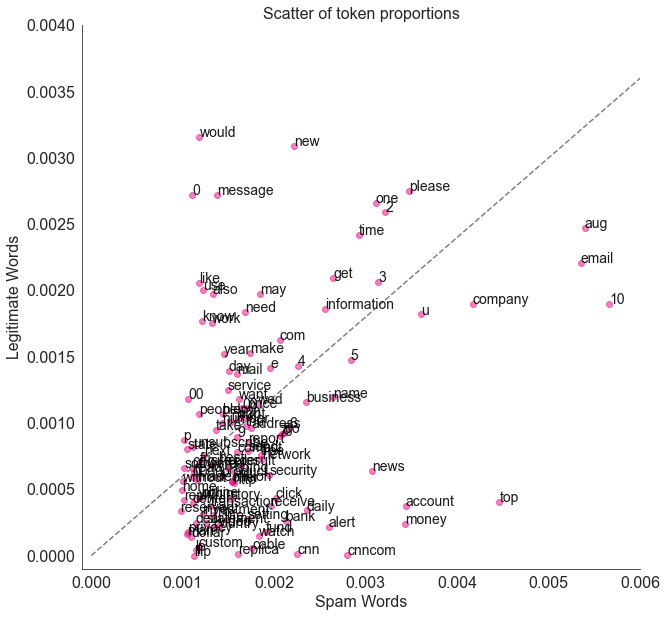

In [54]:
fig, ax = plt.subplots(figsize= (10,10))

# scatterplot:
ax.scatter(spam_legit["proportion_spam"].head(120), spam_legit["proportion_legit"].head(120), color = "#f0027f", alpha = 0.5)

# annotate words:
for i, txt in enumerate(spam_legit["word"].head(120)):
    ax.annotate(txt, 
                (spam_legit["proportion_spam"][i], 
                 spam_legit["proportion_legit"][i]), 
                 color = "black", 
                 alpha = 0.9, fontsize=14)
    
# eliminate grid:
ax.grid(False)

# x axis label:
ax.set_xlabel("Spam Words", fontsize=16)

# y axis label:
ax.set_ylabel("Legitimate Words", fontsize=16)

# diagonal dashed line:
ax.plot([0, 0.02], [0, 0.012], color = "gray", linestyle = "--")

ax.set_title("Scatter of token proportions", fontsize=16)


plt.ylim([-0.0001,0.004])
plt.xlim([-0.0001,0.006])
ax.tick_params(axis='x', labelsize=16)    
ax.tick_params(axis='y', labelsize=16)  

# set spines to false:
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

This representation demonstartes how numbers and terms which are frequanct both on the spam and legitimate emails apear close to the dashed line. 

In [66]:
top_terms = pd.DataFrame({"Top Spam":spam_legit.loc[(spam_legit.proportion_spam > 1e-4) & (spam_legit.proportion_legit < 1e-5)].head(25)["word"].values,
"Top Legitimate": spam_legit.loc[(spam_legit.proportion_spam < 1e-6) & (spam_legit.proportion_legit > 1e-4)].head(25)["word"].values})

In [69]:
top_terms.style.set_properties(**{'background-color': '#FFCFC9','color':'black'},subset=['Top Spam']).set_properties(**{'background-color': '#BEEAE5','color':'black'},subset=['Top Legitimate'])

,Top Spam,Top Legitimate
0,cnncom,hpl
1,lllp,eol
2,30303,syntax
3,kin,linguistics
4,pill,semantic
5,httpwwwcnncomfeedback,suse
6,httpwwwcnncomlinktobnmanagehtml,parsing
7,httpwwwcnncomprivacyhtml,crenshaw
8,anthrax,uai
9,rolex,ena


**Insights:** 
    
- Several links from the CNN news site are frequently included in emails that are tagged as spam.
    
- Legitimate emails often include references to anti-virus services such as `VirScan.org` and `Bitdefender`.
    
- The terms `pill`, `medication` and `Rolex` frequently appear in spam emails, which often likely contain advertisements for suspicious medications and counterfeit luxury brands.

- The terms `syntax`, `suse`, `def`, `pythondev`, `opensuse`, and `python3000` may be related to segments of code that are sent via email.